Index <br>
1) Processing data <br>
2) Training and validation <br>
3) Interprertability

## 1. Preprocessing data

## 1.1 Prepare a csv file with "sentence id", "sentence", "label" as features

Following is the script:<br>
Origin file: <b>paper/aesw_to_sentences.py</b>

In [ ]:
import argparse
import csv
import heapq
import os
from pathlib import Path
from typing import List, Tuple
import pandas as pda
from lxml import etree
from tqdm import tqdm
import numpy as np


def extract_sentence(sent_elem: etree._Element) -> str:
    '''
     extract sentence from the xml.
    '''
    assert sent_elem.tag == "sentence"
    string_builder = [str(sent_elem.text) if sent_elem.text else ""]
    for del_ins in sent_elem:
        if del_ins.tag == "del" and del_ins.text:
            string_builder.append(str(del_ins.text))
        if del_ins.tail:
            string_builder.append(str(del_ins.tail))
    return "".join(string_builder)


def extract_sentence_after_editing(sent_elem: etree._Element) -> str:
    '''
     extract part of the sentence after editing.
    '''
    assert sent_elem.tag == "sentence"
    string_builder = [str(sent_elem.text) if sent_elem.text else ""]

    for del_ins in sent_elem:
        if del_ins.tag == "ins" and del_ins.text:
            string_builder.append(str(del_ins.text))
        if del_ins.tail:
            string_builder.append(str(del_ins.tail))

    return "".join(string_builder)


def extract_sentence_id(sent_elem: etree._Element) -> str:
    '''
     extract sentence id 
    '''
    assert sent_elem.tag == "sentence"
    assert "sid" in sent_elem.attrib
    return str(sent_elem.attrib["sid"])


def get_label(sent_elem: etree._Element) -> int:
    """
    0 if no edit/no change, 1 if changed/edited
    """
    return 1 if len(list(sent_elem)) > 0 else 0


def read_xml(xml_filepath: Path, output_filepath: Path) -> None:
    if os.path.isfile(output_filepath):
        os.remove(output_filepath)

    with open(output_filepath, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["id", "sentence", "label"])

    sentences: List[Tuple[int, str, str, int]] = []

    for event, sent_elem in tqdm(etree.iterparse(str(xml_filepath), tag="sentence")):
        sent_id = extract_sentence_id(sent_elem)
        sent = extract_sentence(sent_elem)
        heapq.heappush(sentences, (len(sent), sent_id, sent, get_label(sent_elem)))

    with open(output_filepath, "a") as file:
        writer = csv.writer(file)
        while sentences:
            _, identifier, sent, label = heapq.heappop(sentences)
            writer.writerow((identifier, sent, label))

In [ ]:
# Call to preprocess

# for test data
test_xml = Path("./data-unversioned/aesw/aesw2016(v1.2)_test_modified.xml")
test_out = Path("./data-unversioned/aesw/aesw-test.csv")
read_xml(test_xml, test_out)

# for dev data
dev_xml = Path("./data-unversioned/aesw/aesw2016(v1.2)_dev.xml")
dev_out = Path("./data-unversioned/aesw/aesw-dev.csv")
read_xml(dev_xml, dev_out)

# for train data
train_xml = Path("./data-unversioned/aesw/aesw2016(v1.2)_train.xml")
train_out = Path("./data-unversioned/aesw/aesw-train.csv")
read_xml(train_xml, train_out)

## 1.2 Tokeize the data and store in pickle file 

Following is the script:

In [ ]:
import bisect
import os
import pickle
import random
import shutil
from pathlib import Path
from typing import Iterator, List, Optional, Tuple, cast, Set

import torch
from torch import Tensor
from torch.utils.data import DataLoader, Sampler, Subset, TensorDataset
from transformers import PreTrainedTokenizerFast

In [ ]:
# Hperparameter class
# origin file: paper/structures.py

from dataclasses import dataclass
import toml
from typing_extensions import Literal


class HyperParameters:
    '''
     initialize training, validation, test folders and other file path and variables used while training
     
    '''
    batch_size: int
    learning_rate: float
    epochs_in_12_hours: int
    train_file: Optional[Path]
    train_folder: Optional[Path]
    train_preprocessed_folder: Path
    val_file: Path
    val_preprocessed_folder: Path
    test_file: Path
    test_preprocessed_folder: Path
    model_name: str
    root_model_name: Optional[str]
    tokenizer_name: str
    models_dir: Path
    experiment_name: str
    checkpoint_interval: float
    vocab_size: int
    checkpoint_csv: Path

    def __init__(self, toml_filepath: str) -> None:
        parsed = toml.load([toml_filepath])

        self.batch_size = int(parsed["batch_size"])
        self.learning_rate = float(parsed["learning_rate"])
        self.max_epochs = int(parsed["max_epochs"])
        self.model_name = parsed["model_name"]
        self.tokenizer_name = parsed["tokenizer_name"]
        self.val_file = Path(parsed["val_file"])
        self.test_file = Path(parsed["test_file"])
        self.experiment_name = parsed["experiment_name"]
        self.models_dir = Path(parsed["models_dir"])
        self.checkpoint_interval = float(parsed["checkpoint_interval"])

        self.train_file = None
        self.train_folder = None
        if "train_file" in parsed:
            self.train_file = Path(parsed["train_file"])
        elif "train_folder" in parsed:
            self.train_folder = Path(parsed["train_folder"])
        else:
            raise ValueError(
                "Must provide either a train_file or a train_folder in .toml file."
            )

        self.root_model_name = None
        if "root_model_name" in parsed:
            self.root_model_name = parsed["root_model_name"]

        self.train_preprocessed_folder = self.get_preprocessed_folder("train")
        self.val_preprocessed_folder = self.get_preprocessed_folder("validate")
        self.test_preprocessed_folder = self.get_preprocessed_folder("test")

        # where will we store the checkpoints file?
        directory, _ = os.path.split(toml_filepath)
        checkpoint_csv_filename = f"{self.experiment_name}-checkpoints.csv"
        self.checkpoint_csv = Path(directory) / checkpoint_csv_filename

    def get_preprocessed_folder(
        self, kind: Literal["train", "validate", "test"]
    ) -> Path:
        suffix = "-preprocessed"
        if kind == "train":
            if self.train_file:
                name, ext = os.path.splitext(self.train_file)
                name += suffix
                assert not os.path.isfile(name)
                os.makedirs(name, exist_ok=True)
                return Path(name)
            elif self.train_folder:
                return self.train_folder.with_name(self.train_folder.name + suffix)
            else:
                raise ValueError(
                    "Must provide either a train_file or a train_folder in .toml file."
                )
        elif kind == "validate":
            name, ext = os.path.splitext(self.val_file)
            name += "-preprocessed"
            assert not os.path.isfile(name)
            os.makedirs(name, exist_ok=True)
            return Path(name)
        elif kind == "test":
            name, ext = os.path.splitext(self.test_file)
            name += "-preprocessed"
            assert not os.path.isfile(name)
            os.makedirs(name, exist_ok=True)
            return Path(name)
        else:
            raise ValueError(f"{kind} is not one of 'train', 'validate' or 'test'.")


In [ ]:
from transformers import AutoTokenizer, PreTrainedTokenizerFast


AESW_TOKENS = ["_MATH_", "_REF_", "_MATHDISP_", "_CITE_"]
AESW_IDS: List[int] = []
BERT_IDS: Set[int] = set()
MAX_LEN = 256


def get_tokenizer(config: HyperParameters) -> PreTrainedTokenizerFast:
    tokenizer = AutoTokenizer.from_pretrained(
        config.tokenizer_name, do_lower_case=True, use_fast=True
    )

    tokenizer.add_special_tokens({"additional_special_tokens": AESW_TOKENS})

    global AESW_IDS
    AESW_IDS = tokenizer.convert_tokens_to_ids(AESW_TOKENS)

    global BERT_IDS
    BERT_IDS = set(tokenizer.all_special_ids) - set(AESW_IDS)

    return tokenizer

def decode(ids: List[int], tokenizer: PreTrainedTokenizerFast) -> str:
    ids = list(filter(lambda i: i not in BERT_IDS, ids))

    return cast(str, tokenizer.decode(ids, skip_special_tokens=False))


def encode_batch(
    sentences: List[str], tokenizer: PreTrainedTokenizerFast,
) -> Tuple[List[Tensor], List[Tensor]]:
    """
    Tokenizes and pads sentences to the max length in the list of sentences. Returns tensors for input ids and tensors for attention masking.
    """
    input_ids: List[List[int]] = []

    for text in sentences:
        tokenized = tokenizer(
            text=text,
            add_special_tokens=True,
            max_length=MAX_LEN,  # Do truncate to MAX_LEN
            truncation=True,  # Do truncate
            padding=False,  # Don't pad
            return_attention_mask=False,
            return_token_type_ids=False,
        )
        input_ids.append(tokenized["input_ids"])

    max_len = max([len(i) for i in input_ids])

    padded_input_ids: List[Tensor] = []
    attention_masks: List[Tensor] = []

    for sent in input_ids:
        num_pads = max_len - len(sent)

        padded_input_ids.append(
            torch.tensor(sent + [tokenizer.pad_token_id] * num_pads)  # type: ignore
        )
        attention_masks.append(torch.tensor([1] * len(sent) + [0] * num_pads))  # type: ignore

    return padded_input_ids, attention_masks


In [ ]:
# data preparation and loading utilities

import itertools
from typing import Any, Iterable, Iterator, List, Optional, Set

import torch

from typing import TypeVar, Union

T = TypeVar("T")

Result = Union[T, Exception]


def is_interactive() -> bool:
    import __main__ as main  # type: ignore

    return not hasattr(main, "__file__")



def import_tqdm() -> Any:
    if is_interactive():
        return __import__("tqdm.notebook").tqdm
    else:
        return __import__("tqdm").tqdm


my_tqdm = import_tqdm()



In [ ]:
import csv
import sys
from pathlib import Path
from typing import IO, Dict, Generic, Iterator, List, NamedTuple, Optional, Tuple


class Peekable(Generic[T]):
    peeked: Optional[T]
    it: Iterator[T]

    def __init__(self, it: Iterator[T]):
        self.peeked = None
        self.it = it

    def peek(self) -> Optional[T]:
        if not self.peeked:
            try:
                self.peeked = next(self.it)
            except StopIteration:
                return None
        return self.peeked

    def pop(self) -> Optional[T]:
        if self.peeked:
            result = self.peeked
            self.peeked = None
            return result
        else:
            try:
                return next(self.it)
            except StopIteration:
                return None

    def __iter__(self) -> Iterator[T]:
        return self.it

class Option(NamedTuple):
    length: int
    identifier: str
    sentence: str
    label: str
    path: Path

def sorted_csv_files_reader(files: List[Path]) -> Iterator[Tuple[str, int]]:
    opened_files: Dict[Path, IO[str]] = {}
    csv_readers: Dict[Path, Peekable[List[str]]] = {}

    for filepath in files:
        opened_file = open(filepath, "r")
        opened_files[filepath] = opened_file

        reader = csv.reader(opened_file)
        next(reader)  # skip header

        csv_readers[filepath] = Peekable(reader)

    while len(opened_files) > 0:
        best = Option(sys.maxsize, "", "", "", Path())
        finished_files = set()

        for path, peekable in csv_readers.items():
            top = peekable.peek()

            if not top:
                finished_files.add(path)
                continue  # should close the file somehow

            identifier, sent, label = top

            if len(sent) < best.length:
                best = Option(len(sent), identifier, sent, label, path)

        # close any finished files:
        for path in finished_files:
            del csv_readers[path]
            opened_files[path].close()
            del opened_files[path]

        # now return the best option and pop it off the iterator
        if best.path not in csv_readers:
            return

        csv_readers[best.path].pop()

        yield best.sentence, int(best.label)


In [ ]:
# function to create data files containing tokenized sentences and masks


Row = Tuple[Tensor, Tensor, Tensor]

class RandomBatchSampler(Sampler):  # type: ignore
    """
    Batches the data into size `batch_size`, then randomly shuffles those batches. Last batch is smaller, because there might not be a full batch.
    """

    def __init__(self, data: TensorDataset, batch_size: int):
        indices = list(range(len(data)))
        batches = [list(g) for g in grouper(indices, batch_size)]

        *front, last = batches

        last = [i for i in last if i]  # filter None out
        random.shuffle(front)

        self.batches = front + [last]

    def __iter__(self) -> Iterator[List[int]]:
        return iter(self.batches)

    def __len__(self) -> int:
        return len(self.batches)

    
class FileBackedSentenceDataset(TensorDataset):
    dirname: Path
    size: int
    files: List[str]
    _file_lens: List[int]
    _index_starts: List[int]
    _cached: Optional[Tuple[str, TensorDataset]]

    def __init__(
        self,
        dirname: Path,
        size: int,
        data_files: Optional[List[Path]] = None,
        tokenizer: Optional[PreTrainedTokenizerFast] = None,
    ):
        """
        Arguments:
        * dirname {str} -- the folder where the pickled TensorDatasets will be stored.
        * data_files {List[str]} -- the original csv file of (sentence, label) pairs. If provided, the sentences should be ordered by length from shortest to longest to make use of smart batches per https://mccormickml.com/2020/07/29/smart-batching-tutorial. If None or empty, then the dataset assumes that the pickled TensorDatasets already exist.
        * tokenizer {Optional[PretrainedTokenizerFast]} -- tokenizer to convert the examples in example_file
        """

        self.dirname = dirname
        self.size = size
        self.files = []
        self._file_lens = []
        self._index_starts = []
        self._cached = None

        if data_files:
            assert tokenizer is not None, "Need a tokenizer with an examples file"
            self._save_all_datasets(data_files, tokenizer)
        else:
            self.files = [
                os.path.join(dirname, f)
                for f in sorted(os.listdir(dirname), key=lambda f: int(f[:-5]))
            ]

            self._file_lens = [self.size for f in self.files]
            # the last file length might be short.
            self._file_lens[-1] = self._get_file_len(self.files[-1])

        start = 0
        for file_len in self._file_lens:
            self._index_starts.append(start)
            start += file_len

    def _save_all_datasets(
        self, data_files: List[Path], tokenizer: PreTrainedTokenizerFast
    ) -> None:
        """
        Each datafile must be sorted by length.
        """
        # clear any existing work
        shutil.rmtree(self.dirname, ignore_errors=True)
        os.makedirs(self.dirname, exist_ok=True)

        sentences = []
        labels = []
        dataset_count = 0

        for sentence, label in my_tqdm(
            sorted_csv_files_reader(data_files)
        ):
            sentences.append(sentence)
            labels.append(label)

            if len(sentences) == self.size:
                self._save_dataset(
                    self._make_dataset(sentences, labels, tokenizer),
                    f"{dataset_count}.pckl",
                )

                dataset_count += 1
                sentences = []
                labels = []

        if sentences:
            self._save_dataset(
                self._make_dataset(sentences, labels, tokenizer),
                f"{dataset_count}.pckl",
            )

    def _make_dataset(
        self,
        sentences: List[str],
        labels: List[int],
        tokenizer: PreTrainedTokenizerFast,
    ) -> TensorDataset:
        """
            Arguments:
            * sentences {List[str]} -- The list of sentences that need to be tokenized and padded. This will always be exactly one batch.
            """
        assert len(sentences) == len(
            labels
        ), "Need the same number of sentences and labels"

        assert (
            len(sentences) <= self.size
        ), f"{len(sentences)} must be less than {self.size}"

        input_ids, attention_masks = encode_batch(sentences, tokenizer)

        input_ids_t = torch.stack(input_ids)
        attention_masks_t = torch.stack(attention_masks)
        labels_t = torch.tensor(labels)  # type: ignore

        dataset = TensorDataset(input_ids_t, attention_masks_t, labels_t)

        return dataset

    def _save_dataset(self, dataset: TensorDataset, name: str) -> None:
        filepath = os.path.join(self.dirname, name)

        self.files.append(filepath)
        self._file_lens.append(len(dataset))

        with open(filepath, "wb") as file:
            pickle.dump(dataset, file)

    def _find_file(self, index: int) -> int:
        """
        Finds the i such that self._index_start[i] <= index < self._index_start[i+1]. Since the array is sorted, we use binary search to find it.
        """
        return bisect.bisect(self._index_starts, index) - 1

    def __getitem__(self, index: int) -> Row:
        file_index = self._find_file(index)
        filename = self.files[file_index]
        dataset: TensorDataset

        if self._cached is None or filename != self._cached[0]:
            # this is called once per batch, so it's working as expected. It's just slow.
            self._set_cached_file(filename)

        name, dataset = self._cached  # type: ignore
        # (OO code sucks, I know that self._cached is no longer None because we call self._set_cached_file)

        return cast(
            Tuple[Tensor, Tensor, Tensor],
            dataset[index - self._index_starts[file_index]],
        )

    def _set_cached_file(self, filename: str) -> None:
        with open(filename, "rb") as f:
            dataset = pickle.load(f)
            self._cached = (filename, dataset)

    def __len__(self) -> int:
        return sum(self._file_lens)

    def _get_file_len(self, filepath: str) -> int:
        with open(filepath, "rb") as f:
            contents: TensorDataset = pickle.load(f)

        return len(contents)


In [ ]:
config_bert = HyperParameters('./experiments/bert_base_aesw_32_1e6/params.toml')
config_scibert = HyperParameters('./experiments/scibert_32_1e6/params.toml')
config_robert = HyperParameters('./experiments/roberta_base_aesw_32_1e6/params.toml')

In [ ]:
# create tokenizer
tokenizer_bert = get_tokenizer(config_bert)
tokenizer_scibert = get_tokenizer(config_scibert)
tokenizer_robert = get_tokenizer(config_robert)

In [ ]:
# fuction to generate train data folders
def prepare_train_data(
    config: HyperParameters, tokenizer: PreTrainedTokenizerFast
) -> None:
    if config.train_file:
        FileBackedSentenceDataset(
            config.train_preprocessed_folder,
            config.batch_size,
            [config.train_file],
            tokenizer,
        )
    elif config.train_folder:
        train_files = [config.train_folder / f for f in os.listdir(config.train_folder)]
        FileBackedSentenceDataset(
            config.train_preprocessed_folder, config.batch_size, train_files, tokenizer,
        )

In [ ]:
# call to above function
prepare_train_data(config_bert, tokenizer_bert)
prepare_train_data(config_scibert, tokenizer_scibert)
prepare_train_data(config_robert, tokenizer_robert)

In [ ]:
def prepare_val_data(
    config: HyperParameters, tokenizer: PreTrainedTokenizerFast
) -> None:
    FileBackedSentenceDataset(
        config.val_preprocessed_folder, config.batch_size, [config.val_file], tokenizer,
    )

In [ ]:
prepare_val_data(config_bert, tokenizer_bert)
prepare_val_data(config_scibert, tokenizer_scibert)
prepare_val_data(config_robert, tokenizer_robert)

In [ ]:
def prepare_test_data(
    config: HyperParameters, tokenizer: PreTrainedTokenizerFast
) -> None:
    FileBackedSentenceDataset(
        config.test_preprocessed_folder,
        config.batch_size,
        [config.test_file],
        tokenizer,
    )

In [ ]:
prepare_test_data(config_bert, tokenizer_bert)
prepare_test_data(config_scibert, tokenizer_scibert)
prepare_test_data(config_robert, tokenizer_robert)

# Training and Validation

## 2.1 Training

In [ ]:
import torch.nn.functional as F
from torch import Tensor, nn
from torch.optim import Optimizer
from transformers import AdamW, AutoModelForSequenceClassification, BertPreTrainedModel

In [ ]:
class SentenceClassificationModel(nn.Module):
    def __init__(self, bert_model: BertPreTrainedModel) -> None:
        super().__init__()  # type: ignore
        self.bert = bert_model

    def forward(self, input_ids: Tensor, attn_mask: Tensor, **kwargs: Any) -> Tensor:
        if "output_attentions" not in kwargs:
            kwargs["output_attentions"] = False

        logits: Tensor = self.bert(input_ids, attention_mask=attn_mask, **kwargs)[0]
        return logits

    def get_optimizer(self, config: HyperParameters) -> Optimizer:
        return AdamW(self.parameters(), lr=config.learning_rate, eps=1e-8)  # type: ignore

In [ ]:
# train utilities

def grouper(
    iterable: Iterable[T], n: int, fillvalue: Optional[T] = None
) -> Iterator[List[T]]:
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

def get_device() -> torch.device:  # type: ignore
    if torch.cuda.is_available():
        return torch.device("cuda")  # type: ignore
    else:
        return torch.device("cpu")  # type: ignore

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(config_bert.model_name)
print(bert.get_input_embeddings())
bert.resize_token_embeddings(len(tokenizer_bert))
print(bert.get_input_embeddings())
model_bert = SentenceClassificationModel(bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Embedding(30522, 768, padding_idx=0)
Embedding(30526, 768)


In [ ]:
scibert = AutoModelForSequenceClassification.from_pretrained(config_scibert.model_name)
print(scibert.get_input_embeddings())
scibert.resize_token_embeddings(len(tokenizer_scibert))
print(scibert.get_input_embeddings())
model_scibert = SentenceClassificationModel(scibert)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Embedding(31090, 768, padding_idx=0)
Embedding(31094, 768)


In [ ]:
robert = AutoModelForSequenceClassification.from_pretrained(config_robert.model_name)
print(robert.get_input_embeddings())
robert.resize_token_embeddings(len(tokenizer_robert))
print(robert.get_input_embeddings())
model_robert = SentenceClassificationModel(robert)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Embedding(50265, 768, padding_idx=1)
Embedding(50269, 768)


In [ ]:
def train_models(model, config, model_name, checkpoint, epoch):
    """
     train different models
    """
    
    optimizer = model.get_optimizer(config)
    
    if checkpoint!=0:
        disk_model = torch.load(os.path.join(config.models_dir,model_name+'_at_epoch_'+str(checkpoint-1)+'.pt'))
        model.load_state_dict(disk_model["model_state_dict"])
        model.to(get_device())
        optimizer.load_state_dict(disk_model["optimizer_state_dict"])

    try:
        model.cuda()
    except:
        pass
    
    epoch = epoch #config.max_epochs
    seen = 0
    loss = 0.0
    
    small = False
    
    # creating train data loader

    train_dataset = FileBackedSentenceDataset(
            config.train_preprocessed_folder, size=config.batch_size
        )

    if small:
        train_dataset = Subset(  # type: ignore
            train_dataset, list(range(min(len(train_dataset), config.batch_size * 8)))
        )

    train_loader = DataLoader(
            train_dataset,
            pin_memory=False,
            batch_sampler=RandomBatchSampler(train_dataset, config.batch_size),
        )
    
    model.train()
    
    for i in range(epoch):
        
        device = get_device()
        epoch_loss = 0
        for seen, batch in enumerate(my_tqdm(train_loader)):

            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            model.zero_grad()

            logits = model(input_ids, attention_mask)

            loss = F.cross_entropy(logits.view(-1, 2), labels.view(-1))

            loss.backward()  # type: ignore

            optimizer.step()

            epoch_loss += loss.detach().item()
        
        
    
        avg_loss = epoch_loss / len(train_loader)    
        print(f"Training loss: {avg_loss:.3f}")
        
        disk_model = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch loss": epoch_loss,
            "avg loss": avg_loss
        }
    
        torch.save(disk_model, os.path.join(config.models_dir, model_name+'_at_epoch_'+str(checkpoint+i)+'.pt'))
        
    disk_model = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(disk_model, os.path.join(config.models_dir, 'final'+model_name+'.pt'))

In [ ]:
train_models(model_bert, config_bert, 'bert', 0, 1)

In [ ]:
train_models(model_scibert, config_scibert, 'scibert.pt', 0, 1)

In [ ]:
train_models(model_robert, config_robert, 'robert.pt', 0, 1)

## 2.2 Validation

In [ ]:
disk_model = torch.load(os.path.join(config_bert.models_dir,'bert_at_epoch_0.pt'))

In [ ]:
# create blank  BERT model
bert = AutoModelForSequenceClassification.from_pretrained(config_bert.model_name)
bert.resize_token_embeddings(len(tokenizer_bert))
model_bert = SentenceClassificationModel(bert)
# create blank optimizer
optimizer_bert = model_bert.get_optimizer(config_bert)

# load model state
model_bert.load_state_dict(disk_model["model_state_dict"])
model_bert.to(get_device())

# load optimizer state
optimizer.load_state_dict(disk_model["optimizer_state_dict"])

In [ ]:
# creating validation data loader

val_dataset = FileBackedSentenceDataset(
        config.val_preprocessed_folder, size=config.batch_size
    )

if small:
    val_dataset = Subset(val_dataset, list(range(config.batch_size * 8)))

val_dataloader = DataLoader(
    val_dataset, shuffle=False, pin_memory=True, batch_size=config.batch_size
)

In [ ]:
@dataclass
class ConfusionMatrix:
    TP: int
    TN: int
    FP: int
    FN: int

    def __add__(self, other: "ConfusionMatrix") -> "ConfusionMatrix":
        return ConfusionMatrix(
            self.TP + other.TP,
            self.TN + other.TN,
            self.FP + other.FP,
            self.FN + other.FN,
        )

    @property
    def accuracy(self) -> float:
        return (self.TP + self.TN) / self.total

    @property
    def f1(self) -> float:
        denominator = self.precision + self.recall

        if denominator == 0:
            print("Both precision and recall were 0; not going to divide by 0.")
            return 0

        return (2 * self.precision * self.recall) / (self.precision + self.recall)

    @property
    def recall(self) -> float:
        if self.TP + self.FN == 0:
            # means there are no negative examples (unlikely)
            print("No negative examples provided; not going to divide by 0.")
            return 1
        return self.TP / (self.TP + self.FN)

    @property
    def precision(self) -> float:
        if self.TP + self.FP == 0:
            # means we didn't guess positive for any examples
            return 0
        return self.TP / (self.TP + self.FP)

    @property
    def total(self) -> int:
        return self.TP + self.FP + self.TN + self.FN

In [ ]:
def get_confusion_matrix(logits: Tensor, labels: Tensor) -> ConfusionMatrix:
    _, predicted = torch.max(logits.data, 1)  # type: ignore

    true_pos: int = ((predicted * labels) != 0).sum().item()
    true_neg: int = (((predicted - 1) * (labels - 1)) != 0).sum().item()
    false_pos: int = ((predicted * (labels - 1)) != 0).sum().item()
    false_neg: int = (((predicted - 1) * labels) != 0).sum().item()

    confusion = ConfusionMatrix(true_pos, true_neg, false_pos, false_neg)

    assert confusion.total == len(
        predicted
    ), f"confusion matrix {confusion} doesn't have the same number of results as {labels}: {confusion.total} != {len(labels)}"

    return confusion

In [ ]:
total_loss = 0
total_confusion = ConfusionMatrix(0,0,0,0)

for batch in my_tqdm(val_dataloader):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)

    loss = F.cross_entropy(logits.view(-1, 2), labels.view(-1))

    total_loss += loss.detach().item()
    total_confusion = total_confusion + get_confusion_matrix(
        logits, labels
    )

avg_loss = total_loss / len(val_dataloader)

print(
    f"""Validation loss: {avg_loss:.3f}
Validation accuracy: {total_confusion.accuracy:.3f}
Validation F1: {total_confusion.f1:.3f}
Validation precision: {total_confusion.precision:.3f}
Validation recall: {total_confusion.recall:.3f}"""
)

100%|██████████| 4608/4608 [52:45<00:00,  1.46it/s]

Validation loss: 0.523
Validation accuracy: 0.737
Validation F1: 0.613
Validation precision: 0.717
Validation recall: 0.535


# 3. Interpretability

## 3.1 Edits 

### There are two type of edits in a sentence "Spell correction edits" and "Word deletion edits".



<p> For each sentence we store a tuple containing following information related to edit operation: 
    
    1. sentence id
    2. raw sentence (unedited)
    3. tokenized (nltk tokenizer) words from the sentence
    4. index of the word which needs edit
    
    Following is the format of storing edits .
    
        (
        < sentence id > ,
        < raw sentence (unedited) >,
        < tokenized (nltk tokenizer) words from the sentence >, 
        < index of the word which needs edit >
        )
    
    example:
    
    Case 1) For sentence containing spell correction edit
            Edit: <sen> I came <del>hame</del><ins>home</ins> early </sen> 
            Storage format : (101. ,"I came hame early" , [[CLS], "I", "came", "hame", "early", [SEP]], [3])
      
    Case 2) For sentence containing word deletion edit
            Edit: <sen> I <del>was</del> came home home early </sen> 
            Storage format : (102. ,"I was came home early" ,[[CLS],"I","was","came","home","early", [SEP]], [2]) 
            
    The tuples are stored in a list. List is stored in a pickle
<p>
            
### We maintain separate picke file for each type of edit namely "spelling.pckl" and "deleted.pckl".
    
![title](https://i.ibb.co/C5Cm9bS/Screenshot-2021-06-14-at-2-50-39-PM.png)

In [ ]:
# utilities
from typing import Iterable, List, TypeVar, NamedTuple

import nltk

T = TypeVar("T")

def tokenize_transformer_sentences(
    sent: str, add_special_tokens: bool = True
) -> List[str]:
    if add_special_tokens:
        sent = "[CLS] " + sent + " [SEP]"

    raw_tokens = nltk.word_tokenize(sent)

    def fix_quotes(token: str) -> str:
        if token == "``":
            return '"'
        if token == "''":
            return '"'
        return token

    raw_tokens = [fix_quotes(token) for token in raw_tokens]

    arbitrary_token = "\t"

    return (
        arbitrary_token.join(raw_tokens)
        .replace(f"[{arbitrary_token}CLS{arbitrary_token}]", "[CLS]")
        .replace(f"[{arbitrary_token}SEP{arbitrary_token}]", "[SEP]")
        .split()
    )

def chunks(elements: Iterator[T], n: int) -> Iterator[List[T]]:
    """
    Yield successive n-sized chunks from elements.
    """

    while True:
        chunk = []
        for i in range(n):
            try:
                chunk.append(next(elements))
            except StopIteration:
                yield chunk
                return

        yield chunk

def get(s: Set[T]) -> T:
    return next(iter(s))

In [ ]:
def get_deleted_word_indices(sent_elem: etree._Element) -> Tuple[List[str], Set[int]]:
    assert sent_elem.tag == "sentence"

    sent_text, mask = extract_sentence_with_mask(sent_elem)
    words = tokenize_transformer_sentences(sent_text, add_special_tokens=False)

    if not any([elem.tag == "del" for elem in sent_elem]):
        return words, set()

    word_i = 0
    word_ch_i = 0
    sent_i = 0

    best_words = set()

    while word_i < len(words) and sent_i < len(sent_text):
        if mask[sent_i] != " ":
            best_words.add(word_i)
        word_ch_i += 1
        sent_i += 1

        if word_ch_i >= len(words[word_i]):
            word_i += 1
            word_ch_i = 0
            # skip whitespace in sent
            while sent_i < len(sent_text) and sent_text[sent_i] in string.whitespace:
                sent_i += 1

        if sent_i >= len(sent_text):
            break

        assert (
            words[word_i][word_ch_i] == sent_text[sent_i]
        ), f"'{words[word_i][word_ch_i]}' != '{sent_text[sent_i]}' ({extract_sentence_id(sent_elem)})"

    words.insert(0, "[CLS]")
    words.append("[SEP]")
    best_words = set([b + 1 for b in best_words])  # all incremented because of [CLS]

    return words, best_words


def extract_sentence_with_mask(sent_elem: etree._Element) -> Tuple[str, str]:
    assert sent_elem.tag == "sentence"
    string_builder = [str(sent_elem.text) if sent_elem.text else ""]
    mask_builder = [" " * len(str(sent_elem.text)) if sent_elem.text else ""]

    for del_ins in sent_elem:
        if del_ins.tag == "del" and del_ins.text:
            string_builder.append(str(del_ins.text))
            mask_builder.append("*" * len(string_builder[-1]))
        if del_ins.tail:
            string_builder.append(str(del_ins.tail))
            mask_builder.append(" " * len(string_builder[-1]))

    assert len(mask_builder) == len(string_builder)

    sent = "".join(string_builder)
    mask = "".join(mask_builder)

    assert len(sent) == len(mask)

    return sent, mask

In [ ]:
import string
from spellchecker import SpellChecker

spell = SpellChecker()

# file paths
DEV_XML = "./data-unversioned/aesw/aesw2016(v1.2)_dev.xml"

INTERPRETABILITY_FOLDER = Path("./data-unversioned/attention-weights/")

class Edit(NamedTuple):
    id: str
    sent: str
    words: List[str]
    best_words: Set[int]
        
def save_edits(edits: List[Edit], filename: str) -> None:
    '''
        method for saving edits
    '''
    with open(INTERPRETABILITY_FOLDER / filename, "wb") as file:
        pickle.dump(edits, file)
        
def load_edits(filename: str) -> List[Edit]:
    """
        method for loading edits
    """
    with open(INTERPRETABILITY_FOLDER / filename, "rb") as file:
        return pickle.load(file)  # type: ignore

def is_only_deleted(sent_elem: etree._Element) -> bool:
    """
        returns True if edit in sentence is of type word deletion
    """
    assert sent_elem.tag == "sentence"

    if len(sent_elem) == 0:
        return False

    for edit_elem in sent_elem:
        if edit_elem.tag != "del":
            return False

    return True

def is_only_spelling_error(sent_elem: etree._Element) -> bool:
    """
        returns True if edit in sentence is of type word correction
    """
    assert sent_elem.tag == "sentence"

    if len(sent_elem) != 2:  # should be one delete, one insert
        return False

    del_elem, ins_elem = list(sent_elem)

    if (
        del_elem.tail
    ):  # should be no text between the deleted text and the inserted text
        return False

    if del_elem.tag != "del" or ins_elem.tag != "ins":
        return False

    misspelled_words = spell.unknown([del_elem.text])

    if not misspelled_words:
        return False

    misspelled_word = get(misspelled_words)

    if misspelled_word in string.whitespace or " " in misspelled_word:
        return False

    corrections = spell.unknown([ins_elem.text])

    if (
        len(corrections) > 0
    ):  # still misspelled, but not always correct. Might want to use edit distance
        return False

    return True

def get_edits_with_only_deleted_words(again: bool = False) -> List[Edit]:
    '''
        
        Stores sentences having spelling errors in a separate file in following format.
        
        [sent_id, sent, words, best_words]
        
        sent_id: unique id of a sentence edit record in DEV file
        sent: actual sentence without any tags
        words: tokenized sentence (nltk tokenizer used)
        best_word: list of indices of tokens in "words" array needing manipulation 
        
        eg: [1, "I was came home early", ["[CLS]", "I", "was","came", "home", "[SEP]"], [2]]
        
    '''
        
    filename = "deleted.pckl"
    try:
        if not again:
            return load_edits(filename)
    except FileNotFoundError:
        pass

    results = []

    for _, sent_elem in my_tqdm(
        etree.iterparse(DEV_XML, tag="sentence")
    ):
        sent_id = extract_sentence_id(sent_elem)
        sent = extract_sentence(sent_elem)
        
        # check if the sentence has edit of type word deletion
        if not is_only_deleted(sent_elem):
            continue
        
        # get tokenized (nltk) sentence and indices of words needing deletion
        words, best_words = get_deleted_word_indices(sent_elem)
        
        # prepare a tuple
        edit = Edit(sent_id, sent, words, best_words)
        
        # store in array
        results.append(edit)

    save_edits(results, filename)

    return results

def get_edits_with_only_spelling_errors(again: bool = False) -> List[Edit]:
    '''
        
        Stores sentences having spelling errors in a separate file in following format.
        
        [sent_id, sent, words, best_words]
        
        sent_id: unique id of a sentence edit record in DEV file
        sent: actual sentence without any tags
        words: tokenized sentence (nltk tokenizer used)
        best_word: list of indices of tokens in "words" array needing manipulation 
        
        eg: [1, "I came hame early", ["[CLS]", "I", "came", "hame", "[SEP]"], [3]]
        
    '''
    
    filename = "spelling.pckl" 
    try:
        if not again:
            return load_edits(filename)
    except FileNotFoundError:
        pass

    results = []

    for _, sent_elem in my_tqdm(
        etree.iterparse(DEV_XML, tag="sentence")
    ):
        sent_id = extract_sentence_id(sent_elem)
        sent = extract_sentence(sent_elem)
        
        # check if the sentence has edit of type spell correction
        if not is_only_spelling_error(sent_elem):
            continue
        
        # get tokenized (nltk) sentence and indices of words needing correction
        words, best_words = get_deleted_word_indices(sent_elem)
        
        # prepare a tuple
        edit = Edit(sent_id, sent, words, best_words)
        
        # store in array
        results.append(edit)

    save_edits(results, filename)

    return results

In [ ]:
# get sentences conatining word deletion change and store in a separate file
deleted_edits = get_edits_with_only_deleted_words()

In [ ]:
# get sentences conatining word spell check change and store in a separate file
spell_edits = get_edits_with_only_spelling_errors(again=True)

147446it [00:01, 80650.26it/s]


## 3.2 Edit weights

### Once the pickle files of respective edits have been made.

### We start storing model specific attention weights of last layer for each sentence to be predicted.

<p><b>For each model: </b><br>
   &emsp;&emsp;<b> For each edit type: </b><br>
   &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Following is the process which we carry out for each and every sentence to be predicted.
</p>
    

![title](https://i.ibb.co/myy70Db/Screenshot-2021-06-14-at-4-41-02-PM.png)


### Output of the above process is stored in pickle file as shown below. 
#### We will have in total  4 ( No. of models ) x 2 ( No. of edit types ) = 8 pickle files 



![title](https://i.ibb.co/WNrWrgp/Screenshot-2021-06-14-at-4-40-41-PM.png)


### Importance of merge attention process.

<p> While prediction we tokenize the input sentences with model specific tokenizer which may produce tokenized words as shown in following example.
    <br> <b>Input sentence :</b> <b>[ I came hame early ]</b>
    <br> <b> Tokenized sentence :</b>
    <br>
</p>

![title](https://i.ibb.co/mD6HZks/Screenshot-2021-06-14-at-4-53-55-PM.png)

<p> But for analysis purpose we would require tokenized sentence in following format </p>

![title](https://i.ibb.co/tpnP3Cj/Screenshot-2021-06-14-at-4-54-05-PM.png)


<p>Following image describes the merge attention process:
    <br>
    Merge attention process transforms the attention matrix as shown below : 
</p>


![title](https://i.ibb.co/P5B1M4V/Screenshot-2021-06-14-at-4-53-44-PM.png)

<p> The obtained attention matrix is used further for analysis. </p>


In [ ]:
from transformers import (
    BertForSequenceClassification,
    BertTokenizerFast,
    PreTrainedModel,
    PreTrainedTokenizerFast,
)

In [ ]:
Model = Tuple[
    SentenceClassificationModel, PreTrainedModel, PreTrainedTokenizerFast
]

def load_finetuned_model_from_disk(
    config: HyperParameters, filepath: Path
) -> Result[Tuple[SentenceClassificationModel, torch.optim.Optimizer]]:
    disk_model: DiskModel

    try:
        if torch.cuda.is_available():
            disk_model = torch.load(filepath)  # type: ignore
        else:
            disk_model = torch.load(filepath, map_location=torch.device("cpu"))  # type: ignore
    except Exception as err:
        return err
    
    bert = AutoModelForSequenceClassification.from_pretrained(config.model_name)

    bert.resize_token_embeddings(len(get_tokenizer(config)))

    model = SentenceClassificationModel(bert)
    optimizer = model.get_optimizer(config)

    model.load_state_dict(disk_model["model_state_dict"])
    model.to(get_device())

    optimizer.load_state_dict(disk_model["optimizer_state_dict"])

    return model, optimizer

def load_bert_default() -> Model:
    """
        load default bert model
    """
    default_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

    if torch.cuda.is_available():
        default_model.cuda()

    cls_model = SentenceClassificationModel(default_model)

    bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    return cls_model, default_model.bert, bert_tokenizer

def load_bert() -> Model:
    """
        load finetuned bert model
    """
    bert_config = HyperParameters(
        "./experiments/bert_base_aesw_32_1e6/params.toml"
    )
    disk_model = load_finetuned_model_from_disk(
        bert_config, Path("./models/bert_at_epoch_0.pt"),
    )
    if isinstance(disk_model, Exception):
        raise disk_model

    bert, _ = disk_model
    bert_tokenizer = get_tokenizer(bert_config)
    return bert, bert.bert.bert, bert_tokenizer

def load_scibert() -> Model:
    """
        load finetuned scibert model
    """
    scibert_config = HyperParameters(
        "./experiments/scibert_32_1e6/params.toml"
    )
    disk_model = load_finetuned_model_from_disk(
        scibert_config,
        Path("./models/scibert_at_epoch_0.pt"),
    )
    if isinstance(disk_model, Exception):
        raise disk_model

    scibert, _ = disk_model
    scibert_tokenizer = get_tokenizer(scibert_config)
    return scibert, scibert.bert.bert, scibert_tokenizer


def load_roberta() -> Model:
    """
        load finetuned roberta model
    """
    roberta_config = HyperParameters(
        "./experiments/roberta_base_aesw_32_1e6/params.toml"
    )
    disk_model = load_finetuned_model_from_disk(
        roberta_config,
        Path("./models/robert_at_epoch_0.pt"),
    )
    if isinstance(disk_model, Exception):
        raise disk_model

    roberta, _ = disk_model
    roberta_tokenizer = get_tokenizer(roberta_config)
    return roberta, roberta.bert.roberta, roberta_tokenizer

def get_all_models(finetuned_only: bool = False) -> Dict[str, Model]:
    """
        load all models
    """
    if finetuned_only:
        return {
            "bert": load_bert(),
            "scibert": load_scibert(),
            "roberta": load_roberta(),
        }
    else:
        return {
            "bert": load_bert(),
            "scibert": load_scibert(),
            "roberta": load_roberta(),
#             "bert_glue": load_bert_glue(),
            "bert_default": load_bert_default(),
        }

In [ ]:
class ModelOutput(NamedTuple):
    words: List[str]
    attention: np.ndarray
    prediction: bool

Cache = Dict[str, Tuple[List[str], np.ndarray, bool]]

def get_word_ends_from_tokens(tokens: List[str], words: List[str]) -> List[str]:
    assert tokens[0] == words[0], f"{tokens[0]} != {words[0]}"
    assert tokens[-1] == words[-1]

    word_ends = []

    word_i = 0
    token_i = 0
    while word_i < len(words) and token_i < len(tokens):
        if words[word_i].lower().endswith(tokens[token_i].lower().strip()):
            word_ends.append(tokens[token_i])
            word_i += 1

        token_i += 1

    return word_ends


def format_special_chars(tokens: List[str]) -> List[str]:
    return [
        t.replace("Ġ", " ").replace("▁", " ").replace("</w>", "").replace("##", "")
        for t in tokens
    ]

def merge_attention_head(
    attention_head: np.ndarray,
    tokens: List[str],
    words: List[str],
    word_ends: List[str],
    verbose: int = 0,
) -> np.ndarray:
    
    
    """
        returns attention block of shape 12 x len(words) x len(words)
        where , words = words array obtained after tokenization of sentence with nltk tokenizer
    """
    assert attention_head.shape == (len(tokens), len(tokens)), str(attention_head.shape)

    if verbose == 1:
        print(attention_head.shape)
        print()
    if verbose == 2:
        print(attention_head)
        print()

    # step 1: merge attention *to* split words

    merged_attention = np.zeros((len(tokens), len(words)))

    for token_i, token_from in enumerate(tokens):
        attention_sum = 0
        word_j = -1
        for token_j, token_to in enumerate(tokens):
            attention_sum += attention_head[token_i, token_j]
            if token_to in word_ends[word_j + 1 :]:
                word_j = word_ends.index(token_to, word_j + 1)
                merged_attention[token_i, word_j] = attention_sum
                attention_sum = 0

    if verbose == 1:
        print(merged_attention.shape)
        print()
    if verbose == 2:
        print(merged_attention)
        print()

    final_attention = np.zeros((len(words), len(words)))

    # step 2: merge attention *from* split words

    for word_j, word in enumerate(words):
        word_i = -1
        attention_to_word = 0
        tokens_to_word_count = 0
        for token_i, token in enumerate(tokens):
            attention_to_word += merged_attention[token_i, word_j]
            tokens_to_word_count += 1

            if token in word_ends[word_i + 1 :]:
                word_i = word_ends.index(token, word_i + 1)
                attention_from_word = attention_to_word / tokens_to_word_count
                final_attention[word_i, word_j] = attention_from_word
                attention_to_word = 0
                tokens_to_word_count = 0

    if verbose == 1:
        print(final_attention.shape)
        print()
    if verbose == 2:
        print(final_attention)
        print()

    return final_attention

def get_words_and_attention_and_prediction(
    sents: List[str],
    cls_model: SentenceClassificationModel,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerFast,
) -> List[ModelOutput]:
    """
     returns words, merged attentions, predictions for a particular sentence edit
    """
    if not sents:
        return []
    
    # tokenize(nltk) each and every sentence in a batch
    words = [tokenize_transformer_sentences(sent) for sent in sents]
    
    # tokenize the sentence with model specific tokenizers to send the tokenized word array for prediction
    inputs = tokenizer.batch_encode_plus(
        sents, return_tensors="pt", add_special_tokens=True, padding=True
    )

    device = get_device()
    
    # extract tokenized words
    input_ids = inputs["input_ids"].to(device)
    # extract mask of determining tokenied words + padding
    attn_mask = inputs["attention_mask"].to(device)
    
    # perform batch prediction
    with torch.no_grad():
        attention = model(input_ids, output_attentions=True)[-1]

        logits = cls_model(input_ids, attn_mask=attn_mask)
        _, raw_predictions = torch.max(logits.data, 1)  # type: ignore

        predictions: List[int] = raw_predictions.tolist()

    # attention is a tuple of length 12
    # each element in attention is a tensor len(sents) x 12 x max_seq_len x max_seq_len

    results = []

    for i in range(len(sents)):
        # get tokens
        input_id_list = input_ids[i].tolist()
        tokens: List[str] = tokenizer.convert_ids_to_tokens(input_id_list)

        tokens[0] = "[CLS]"

        # last token isn't always [SEP] so we normalize
        last_token = tokens.index(tokenizer.sep_token)
        tokens[last_token] = "[SEP]"

        # only care about non-padding tokens
        tokens = tokens[: last_token + 1]
        tokens = format_special_chars(tokens)
        
        # getting word ends of each nltk-tokenized word from words tokenized with model tokenizer 
        word_ends = get_word_ends_from_tokens(tokens, words[i])

        # get attention and remove the values that should be masked
        word_attention = []
        
        # call merge attention for attention block of each of the 12 attention heads
        for attention_head in attention[11][i]:
            relevant_attn = attention_head.numpy()[: last_token + 1, : last_token + 1]
            word_attn = merge_attention_head(relevant_attn, tokens, words[i], word_ends)
            word_attention.append(word_attn)

        word_attention_arr: np.ndarray = np.stack(word_attention, axis=0)

        results.append(ModelOutput(words[i], word_attention_arr, bool(predictions[i])))

    return results


def get_attention_weights(
    edits: Iterable[Edit],
    cls_model: SentenceClassificationModel,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerFast,
    skip_false_predictions: bool = False,
) -> Cache:
    """
       returns saved list containing tuples of format (words, attn, prediction) 
       where 
           words: tokenized(nltk) words from sentence.
           attn: attention of CLS bit of last level.
           prediction: output of prediction 0 or 1.
    """
    saved = {}

    for edit_batch in my_tqdm(chunks(iter(edits), 8)):
        sents = [edit.sent for edit in edit_batch]
        
        # get tokenized(nltk) words , attention weights, prediction(0 or 1)
        result = get_words_and_attention_and_prediction(
            sents, cls_model, model, tokenizer
        )

        for edit, (words, attn, prediction) in zip(edit_batch, result):
            if skip_false_predictions and not prediction:
                continue

            if edit.words != words:
#                 print(edit.id)
#                 print(edit.words)
#                 print(words)
                continue

            saved[edit.id] = (words, attn, prediction)

    return saved


PICKLE_FOLDER = Path("./data-unversioned/attention-weights/")

def save_model_cache(model_name: str, filename: str, cache: Cache) -> None:
    """
        method for saving model weights
    """   
    with open(PICKLE_FOLDER / model_name / filename, "wb") as file:
        pickle.dump(cache, file)
        
def load_model_cache(model_name: str, filename: str) -> Cache:
    """
        method for loading model weights
    """
    with open(PICKLE_FOLDER / model_name / filename, "rb") as file:
        return pickle.load(file)  # type: ignore
    
def save_edit_weights(all_edits: Iterable[Edit], filename: str) -> None:
    """
        predict from one model at a time and save attention weights after prediction.
    """
    all_models = get_all_models()
    
    # save all the weights
    for model_name, (cls_model, model, tokenizer) in all_models.items():
        cache = get_attention_weights(all_edits, cls_model, model, tokenizer)
        save_model_cache(model_name, filename, cache)

In [ ]:
# extract attention weights of last layer's CLS head of BERT model, on prediction over sentences needing word 
# deletion edit. 
DELETE_EDIT_WEIGHTS_FILENAME = "deleted.pckl"
save_edit_weights(deleted_edits, DELETE_EDIT_WEIGHTS_FILENAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# extract attention weights of last layer's CLS head of BERT model, on prediction over sentences needing spell 
# correction edit. 

SPELLING_EDIT_WEIGHTS_FILENAME = "spelling.pckl"
save_edit_weights(spell_edits, SPELLING_EDIT_WEIGHTS_FILENAME)

## 3.3 Evaluation of scores

The steps involved in evaluation process are as follows:

<p> For each model: <br>
&emsp;For each sentence: <br>
&emsp;&emsp;We do following procedure.
</p>

![title](https://i.ibb.co/Y0BK0nt/Screenshot-2021-06-14-at-7-23-41-PM.png)

<p>
After completing above procedure we compute following. <br>

For each model:<br>
&emsp;&emsp;For each strategy:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;1. exact_match_accuracy <br>
&emsp;&emsp;&emsp;&emsp;&emsp;2. jaccard_match_accuracy <br>
&emsp;&emsp;&emsp;&emsp;&emsp;3. mean_jaccard_similarity <br>
&emsp;&emsp;&emsp;&emsp;&emsp;4. top_3_match_accuracy <br>
</p>


<p> Metrics Formulation: </p>

Lets consider prediction for sentence <b>"I came hame early"</b>. <br>
In the above sentence "hame" word is spelled incorrectly so it should be targeted by BERT during prediction.
<br>
Let, target = ['hame']
<br>
Lets assume BERT attended following array of words in decreasing order of attention.<br>
Let, attended_words = ['hame', 'early', 'came', 'I']

<b>exact_match</b>  = During a prediction, if BERT paid attention to all the actual targets or spelling mistake words in prediction then we increment this variable.<br>

&emsp;&emsp;&emsp;&emsp;&emsp;So in our example all the targets words were attended by BERT i-e, <br>

&emsp;&emsp;&emsp;&emsp;&emsp; target == attended_words[:len(target)] <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-e {'hame'}=={'hame'} <br>
&emsp;&emsp;&emsp;&emsp;&emsp;So we increment, exact_match.<br>
<br>
<b>exact_match_accuracy</b> = exact_match / num_predictions
<br>

<b>top_3_match</b> = During a prediction, if target words set is found to be subset of top 3 attended words, then we increment top 3 match count.

&emsp;&emsp;&emsp;&emsp;&emsp;So in our example the targets words are subset of words attended by BERT i-e, <br>

&emsp;&emsp;&emsp;&emsp;&emsp; target <= attended_words[:3] <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-e {'hame'}<={'hame', 'early', 'came'} <br>
&emsp;&emsp;&emsp;&emsp;&emsp;So we increment, top_3_match.<br>
<br>
<b>top_3_match_accuracy</b> = top_3_match / num_predictions
<br>

<b> jaccard_sim </b> = Jaccard sim, of target words and attended words.

&emsp;&emsp;&emsp;&emsp;&emsp; jaccard_sim = len( target & attended_words[:len(target)] ) / len( target U attended_words[:len(target)] ) <br>

&emsp;&emsp;&emsp;&emsp;&emsp;So in our example,  jaccard_sim = 1<br>
&emsp;&emsp;&emsp;&emsp;&emsp; Since, len({'hame'} & {'hame'}) / len({'hame'} U {'hame'}) = 1

<br>
<b> jaccard_match </b>= If jaccard_sim > 0.5 we increment jaccard_match.
<br>

<b>jaccard_match_accuracy</b> = jaccard_match / num_predictions







In [ ]:
# Use attention weights to calculate similarity scores and accuracy

# utilities
import statistics

def multi_index(lst: List[T], indices: Iterable[int]) -> List[T]:
    result = []
    for i in indices:
        result.append(lst[i])
    return result


@dataclass
class Prediction:
    id: str
    target: Set[int]
    predictions: List[int]  # ordered but unique. From a prediction for an id

    def top_n(self, n: Optional[int] = None) -> Set[int]:
        """
        if n is not provided, use len(self.target)
        """
        if n is None:
            n = len(self.target)

        return set(self.predictions[:n])

    def jaccard_similarity(self, n: Optional[int] = None) -> float:
        """
        if n is not provided, use len(self.target)
        """
        if n is None:
            n = len(self.target)

        return len(self.target & self.top_n(n)) / len(self.target | self.top_n(n))
    
    
@dataclass
class EvalStrategyResult:
    exact_match_accuracy: float = 0
    jaccard_match_accuracy: float = 0
    mean_jaccard_similarity: float = 0
    top_3_match_accuracy: float = 0

In [ ]:
Strategy = Literal["sum", "max"]

def get_best_choices(attn: np.ndarray, strategy: Strategy) -> List[int]:
    """
        
    """
    heads, words = attn.shape
    assert heads == 12

    if strategy == "sum":
        attn = attn.sum(axis=0)
    elif strategy == "max":
        attn = attn.max(axis=0)  # prevents picking the same word twice
    else:
        raise ValueError(strategy)

    assert len(attn) == words, f"should be {words} different options; got {len(attn)}"

    indices = attn.argsort()[::-1]  # gets indices from max attention to min attention
    best_choices: List[int] = indices.tolist()

    # filter first and last word because it's [CLS] and [SEP]
    best_choices.remove(0)  # [CLS]
    best_choices.remove(max(best_choices))  # [SEP]

    return best_choices

def get_universal_correct_predictions(weights_filename: str) -> Set[str]:
    """
        returns sentence id for which all the models give correct predictions.
    """
    bert_correct_predictions = set()

    bert_cache = load_model_cache("bert", weights_filename)
    for sent_id, (_, _, prediction) in bert_cache.items():
        if prediction:
            bert_correct_predictions.add(sent_id)

    roberta_correct_predictions = set()

    roberta_cache = load_model_cache("roberta", weights_filename)
    for sent_id, (_, _, prediction) in roberta_cache.items():
        if prediction:
            roberta_correct_predictions.add(sent_id)

    scibert_correct_predictions = set()

    scibert_cache = load_model_cache("scibert", weights_filename)
    for sent_id, (_, _, prediction) in scibert_cache.items():
        if prediction:
            scibert_correct_predictions.add(sent_id)

    universal = (
        bert_correct_predictions
        & scibert_correct_predictions
        & roberta_correct_predictions
    )

    assert len(universal) <= len(bert_correct_predictions)
    assert len(universal) <= len(scibert_correct_predictions)
    assert len(universal) <= len(roberta_correct_predictions)

    return universal

def get_random_predictions(edits: List[Edit]) -> List[Prediction]:
    """
        a random model which just gives attention to words in random fashion.
    """
    random.seed(42)

    results = []

    for edit in edits:

        possible_indices = list(
            range(1, len(edit.words) - 1)
        )  # 1 to skip [CLS], len(edit.words)-1 to skip [SEP]
        random.shuffle(possible_indices)
        assert 0 not in possible_indices
        assert len(edit.words) - 1 not in possible_indices
        best_word_predictions = possible_indices

        target_words = multi_index(edit.words, edit.best_words)
        assert "[CLS]" not in target_words, edit
        assert "[SEP]" not in target_words, edit

        if not target_words:
            continue

        predicted_words = multi_index(edit.words, best_word_predictions)
        assert "[CLS]" not in predicted_words, best_word_predictions
        assert "[SEP]" not in predicted_words, best_word_predictions

        results.append(Prediction(edit.id, edit.best_words, best_word_predictions))

    return results

def cls_attn(last_layer_attn: np.ndarray) -> np.ndarray:
    """
        extract attention given by "[CLS]" sub string to all other substrings
    """
    heads, words_from, words_to = last_layer_attn.shape
    assert heads == 12, heads
    assert words_from == words_to

    # [:, 0, :] picks the [CLS] token's attention to all words for all heads
    return last_layer_attn[:, 0, :]

def use_strategy(
    edits: List[Edit], strategy: Strategy, attn_cache: Cache,
) -> List[Prediction]:
    
    """
       returns actual target words which need edition and word to which we paid attention during prediction.
       
    """
    results = []

    for edit in edits:
        if edit.id not in attn_cache:
            continue  # tokenization error
        words, attn, prediction = attn_cache[edit.id]

        assert words == edit.words, f"{words} != {edit.words}"

        best_word_predictions = get_best_choices(cls_attn(attn), strategy)

        target_words = multi_index(words, edit.best_words)
        assert "[CLS]" not in target_words, edit
        assert "[SEP]" not in target_words, edit

        predicted_words = multi_index(words, best_word_predictions)
        assert "[CLS]" not in predicted_words, best_word_predictions
        assert "[SEP]" not in predicted_words, best_word_predictions
        
        if len(edit.best_words) >0:
            results.append(Prediction(edit.id, edit.best_words, best_word_predictions))

    return results


def evaluate_strategy(predictions: List[Prediction]) -> EvalStrategyResult:
    """
        returns tuple of metrics 
        
        Calculate following metrics:
        
        exact_match_accuracy 
        jaccard_match_accuracy 
        statistics.mean(jaccard_sims) 
        top_3_accuracy 
                
    """
    total = len(predictions)
    if not total:
        return EvalStrategyResult()

    exact_matches = 0
    jaccard_sims = []
    top_3_matches = 0

    for prediction in predictions:
#         print(prediction)
        if prediction.target == prediction.top_n():
            exact_matches += 1

        if prediction.target <= prediction.top_n(3):
            
            # subset operation
            assert len(prediction.target) > 0
            top_3_matches += 1

        jaccard_sims.append(prediction.jaccard_similarity())

    exact_match_accuracy = exact_matches / total
    top_3_accuracy = top_3_matches / total

    jaccard_match_accuracy = len([s for s in jaccard_sims if s >= 0.5]) / total

    return EvalStrategyResult(
        exact_match_accuracy,
        jaccard_match_accuracy,
        statistics.mean(jaccard_sims),
        top_3_accuracy,
    )

In [ ]:

def evaluate_all_strategies_on_spelling_edits() -> None:
    """
        saves scores calculated by both "sum" and "max" strategy for each model in a json file.
    
    """
    spelling_edits = get_edits_with_only_spelling_errors()

    all_strategies: List[Strategy] = ["sum", "max"]

    skip_false_predictions_models = [
        "bert",
        "scibert",
        "roberta",
        "bert_default",
#         "bert_glue",
    ]

    scores: List[Score] = []
    
    # get sentence id to which all the models gave correct prediction
    universal = get_universal_correct_predictions(SPELLING_EDIT_WEIGHTS_FILENAME)

    for model_name in skip_false_predictions_models:
        # load the weights for a model
        cache = load_model_cache(model_name, SPELLING_EDIT_WEIGHTS_FILENAME)

        # analyse only those predictions that all models get correct.
        cache = {key: value for key, value in cache.items() if key in universal}

        # for each strategy and type of edit, make a bunch of guesses
        for strategy in all_strategies:
            # for each prediction get a tuple containing pred id target words and 
            # words to which we gave attention in sorted fashion 
            predictions = use_strategy(spelling_edits, strategy, cache,)
            
            # calculate metrics
            result = evaluate_strategy(predictions)
            
            # store calculated metrics in a list
            scores.append(
                Score(
                    model_name,
                    strategy,
                    result.exact_match_accuracy,
                    result.jaccard_match_accuracy,
                    result.mean_jaccard_similarity,
                    result.top_3_match_accuracy,
                    False,
                )
            )

    random_predictions = get_random_predictions(spelling_edits)

    result = evaluate_strategy(random_predictions)

    scores.append(
        Score(
            "random",
            "sum",
            result.exact_match_accuracy,
            result.jaccard_match_accuracy,
            result.mean_jaccard_similarity,
            result.top_3_match_accuracy,
            False,
        )
    )

    scores.append(
        Score(
            "random",
            "max",
            result.exact_match_accuracy,
            result.jaccard_match_accuracy,
            result.mean_jaccard_similarity,
            result.top_3_match_accuracy,
            False,
        )
    )

    with open(
        "./data-unversioned/attention-weights/scores/spelling-edit.json", "w"
    ) as file:
        json.dump(scores, file, indent=4, cls=ScoreEncoder)


In [ ]:
from dataclasses import dataclass
from typing import Any, Optional



@dataclass
class Score:
    model_name: str
    strategy: Strategy
    exact_match_accuracy: float
    jaccard_match_accuracy: float
    avg_jaccard_similarity: float
    top_3_match_accuracy: float
    skipped_false_predictions: bool

    @staticmethod
    def parse(dct: Any) -> Optional["Score"]:
        if "__Score__" in dct and dct["__Score__"]:
            # parse it
            return Score(
                dct["model name"],
                dct["strategy"],
                dct["exact match accuracy"],
                dct["jaccard match accuracy"],
                dct["avg jaccard similarity"],
                dct["top 3 match accuracy"],
                dct["skipped false predictions"],
            )
        else:
            return None


class ScoreEncoder(json.JSONEncoder):
    def default(self, o: Any) -> Any:
        if not isinstance(o, Score):
            return super().default(o)

        return {
            "__Score__": True,
            "model name": o.model_name,
            "strategy": o.strategy,
            "exact match accuracy": o.exact_match_accuracy,
            "jaccard match accuracy": o.jaccard_match_accuracy,
            "avg jaccard similarity": o.avg_jaccard_similarity,
            "top 3 match accuracy": o.top_3_match_accuracy,
            "skipped false predictions": o.skipped_false_predictions,
        }


In [ ]:
evaluate_all_strategies_on_spelling_edits()

In [ ]:
def evaluate_all_strategies_on_delete_edits() -> None:
    delete_edits = get_edits_with_only_deleted_words()

    all_strategies: List[predict.Strategy] = ["sum", "max"]

    skip_false_predictions_models = [
        "bert",
        "scibert",
        "roberta",
        "bert_default",
#         "bert_glue",
    ]

    scores: List[Score] = []

    universal = get_universal_correct_predictions(DELETE_EDIT_WEIGHTS_FILENAME)

    for model_name in skip_false_predictions_models:
        # load the weights for a model
        cache = load_model_cache(model_name, DELETE_EDIT_WEIGHTS_FILENAME)

        # only do predictions that all models get
        cache = {key: value for key, value in cache.items() if key in universal}

        # for each strategy and type of edit, make a bunch of guesses
        for strategy in all_strategies:

            predictions = use_strategy(delete_edits, strategy, cache)

            result = evaluate_strategy(predictions)

            scores.append(
                Score(
                    model_name,
                    strategy,
                    result.exact_match_accuracy,
                    result.jaccard_match_accuracy,
                    result.mean_jaccard_similarity,
                    result.top_3_match_accuracy,
                    False,
                )
            )

    random_predictions = get_random_predictions(delete_edits)

    result = evaluate_strategy(random_predictions)

    scores.append(
        Score(
            "random",
            "sum",
            result.exact_match_accuracy,
            result.jaccard_match_accuracy,
            result.mean_jaccard_similarity,
            result.top_3_match_accuracy,
            False,
        )
    )

    scores.append(
        Score(
            "random",
            "max",
            result.exact_match_accuracy,
            result.jaccard_match_accuracy,
            result.mean_jaccard_similarity,
            result.top_3_match_accuracy,
            False,
        )
    )

    with open(
        "./data-unversioned/attention-weights/scores/delete-edit.json", "w"
    ) as file:
        json.dump(scores, file, indent=4, cls=ScoreEncoder)

In [ ]:
evaluate_all_strategies_on_delete_edits()

## 3.4 Plotting scores

In [ ]:
SPELLING_SCORES_FILE = "spelling-edit.json"
INTERPRETABILITY_FOLDER = Path("./data-unversioned/attention-weights/")
SCORES_FOLDER = INTERPRETABILITY_FOLDER / "scores"
DELETE_SCORES_FILE = "delete-edit.json"

def get_scores(filename: str) -> List[Score]:
    assert filename.endswith(".json")

    with open(SCORES_FOLDER / filename) as file:
        score_dict_list = json.load(file)

    parsed = [Score.parse(score) for score in score_dict_list]
    return [s for s in parsed if s]

def get_relevant_scores(
    scores: List[Score],
) -> Tuple[Score, Score, Score, Score, Score, Score]:
    """
    returns a list of scores for
    * Random
    * BERT_default-sum
    * BERT_GLUE-sum
    * BERT-sum
    * SciBERT-sum
    * RoBERTA-sum
    """

    random = next(score for score in scores if score.model_name == "random")

    bert_default_sum = next(
        score
        for score in scores
        if score.model_name == "bert_default" and score.strategy == "sum"
    )

#     bert_glue_sum = next(
#         score
#         for score in scores
#         if score.model_name == "bert_glue" and score.strategy == "sum"
#     )

    bert_sum = next(
        score
        for score in scores
        if score.model_name == "bert" and score.strategy == "sum"
    )

    scibert_sum = next(
        score
        for score in scores
        if score.model_name == "scibert" and score.strategy == "sum"
    )

    roberta_sum = next(
        score
        for score in scores
        if score.model_name == "roberta" and score.strategy == "sum"
    )

#     return (random, bert_default_sum, bert_glue_sum, bert_sum, scibert_sum, roberta_sum)
    return (random, bert_default_sum, bert_sum, scibert_sum, roberta_sum)


In [ ]:
spell_scores = get_relevant_scores(get_scores(SPELLING_SCORES_FILE))

In [ ]:
del_scores = get_relevant_scores(get_scores(DELETE_SCORES_FILE))

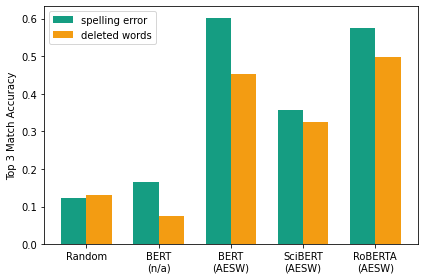

In [ ]:
# plotting functions

from typing import Collection
import matplotlib.pyplot as plt

# region colors

BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

def model_name_to_model_and_dataset(model_name: str) -> Tuple[str, str]:
    model_name = model_name.lower()
    if model_name == "bert_default":
        return "BERT", "n/a"
#     elif model_name == "bert_glue":
#         return "BERT", "GLUE"
    elif model_name == "bert":
        return "BERT", "AESW"
    elif model_name == "roberta":
        return "RoBERTA", "AESW"
    elif model_name == "scibert":
        return "SciBERT", "AESW"
    elif model_name == "random":
        return "Random", ""
    else:
        raise ValueError(f"{model_name} is not a valid name")

def format_x_label(name: str, data: str) -> str:
    if data:
        return f"{name}\n({data})"
    else:
        return name


def plot_n_bars(
    x: Collection[str], y_points: Collection[Iterable[float]], y_labels: Collection[str]
) -> None:
    width = 0.7 / len(y_points)  # the width of the bars

    x_pos = np.arange(len(x))

    fig, ax = plt.subplots()

    colors = [SEA, ORANGE, BLUE]
    rects = []
    for i, (y, c) in enumerate(zip(y_points, colors)):
        rects.append(ax.bar(x_pos + i * width, y, width, color=c)[0])

    ax.set_ylabel("Top 3 Match Accuracy")
    ax.set_xticks(x_pos + (len(y_points) / 2 - 0.5) * width)
    ax.set_xticklabels(x)
    ax.legend(rects, y_labels)

    fig.tight_layout()



points = [
        (
            format_x_label(
                *model_name_to_model_and_dataset(spell_score.model_name)
            ),
            spell_score.top_3_match_accuracy,
            del_score.top_3_match_accuracy,
        )
        for spell_score, del_score in zip(spell_scores, del_scores)
    ]

xlabels, y_spelling, y_delete = zip(*points)

plot_n_bars(
    xlabels, (y_spelling, y_delete), ("spelling error", "deleted words"),
)

plt.show()


## Comparing attentions of each model

In [ ]:
# Create individual plots comparing each model's attention on a single sentence

In [ ]:
import matplotlib

def plot_cls_attention(
    tokens: List[str], attn: np.ndarray, title: str, word_ticks: bool, ax: Any = None
) -> Any:
    # https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
    heads = list(range(12))

    if not ax:
        ax = plt.gca()

    im = ax.imshow(
        attn.T, cmap="Reds", norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
    )

    ax.set_xticks(np.arange(len(heads)))
    ax.set_xticklabels([])
    ax.set_xlabel("Attention Heads")

    if word_ticks:
        ax.set_yticks(np.arange(len(tokens)))
        ax.set_yticklabels(tokens, size=12)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_title(title)
    return im

def plot_word_level_attention(
    sent: str,
    cls_model: SentenceClassificationModel,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerFast,
    title: str,
    word_ticks: bool,
    **plotkwargs: Any,
) -> Any:
    output = get_words_and_attention_and_prediction(
        [sent], cls_model, model, tokenizer
    )[0]

    title += f" ({'needs edit' if output.prediction else 'no edit'})"

    return plot_cls_attention(
        output.words, cls_attn(output.attention), title, word_ticks, **plotkwargs
    )


def plot_all_word_models(sentence: str) -> None:
    height = 2 + 0.2 * len(tokenize_transformer_sentences(sentence))
    fig, axes = plt.subplots(1, 3, figsize=(12, height), constrained_layout=True)

    ((ax1, ax2, ax3)) = axes

    bert_cls, bert, bert_tokenizer = load_bert()

    im = plot_word_level_attention(
        sentence, bert_cls, bert, bert_tokenizer, title="BERT", word_ticks=True, ax=ax1
    )

    scibert_cls, scibert, scibert_tokenizer = load_scibert()

    im = plot_word_level_attention(
        sentence,
        scibert_cls,
        scibert,
        scibert_tokenizer,
        title="SciBERT",
        word_ticks=False,
        ax=ax2,
    )

    roberta_cls, roberta, roberta_tokenizer = load_roberta()

    im = plot_word_level_attention(
        sentence,
        roberta_cls,
        roberta,
        roberta_tokenizer,
        title="RoBERTa",
        word_ticks=False,
        ax=ax3,
    )

    # fig.tight_layout()

    cbar = fig.colorbar(
        im,
        ax=axes.ravel().tolist(),
        orientation="horizontal",
        aspect=30,
        use_gridspec=True,
    )
    cbar.ax.set_xlabel("Attention", va="center")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

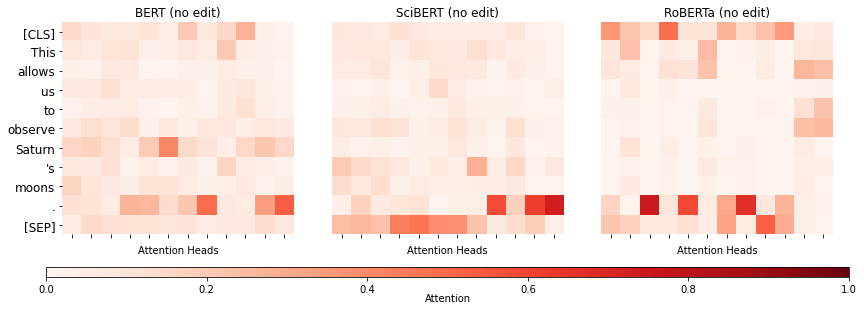

In [ ]:
plot_all_word_models("This allows us to observe Saturn's moons.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

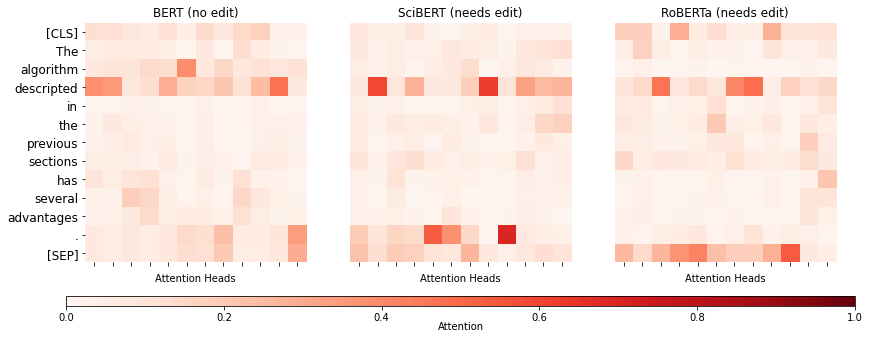

In [ ]:
plot_all_word_models("The algorithm descripted in the previous sections has several advantages.")

## Compare fine tuned BERT with default BERT

In [ ]:
def plot_finetuned_models_comparison(sentence: str) -> None:
    height = 2 + 0.2 * len(tokenize_transformer_sentences(sentence))
    fig, axes = plt.subplots(1, 2, figsize=(12, height), constrained_layout=True)

    ((ax1, ax2)) = axes

    bert_default_cls, bert_default, bert_default_tokenizer = load_bert_default()

    im = plot_word_level_attention(
        sentence,
        bert_default_cls,
        bert_default,
        bert_default_tokenizer,
        title="Before",
        word_ticks=True,
        ax=ax1,
    )

    bert_cls, bert, bert_tokenizer = load_bert()

    im = plot_word_level_attention(
        sentence,
        bert_cls,
        bert,
        bert_tokenizer,
        word_ticks=False,
        title="After",
        ax=ax2,
    )

    # fig.tight_layout()

    cbar = fig.colorbar(
        im,
        ax=axes.ravel().tolist(),
        orientation="horizontal",
        aspect=30,
        use_gridspec=True,
    )
    cbar.ax.set_xlabel("Attention", va="center")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

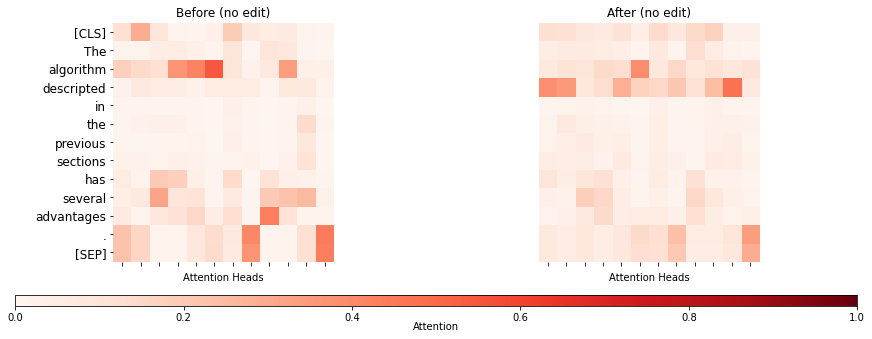

In [ ]:
plot_finetuned_models_comparison("The algorithm descripted in the previous sections has several advantages.")